In [26]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
from tifffile import imread
from glob import glob
from scipy.stats import mode
from collections import Counter
import math
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx

In [2]:
file = "B2"

fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-test/tracks/{file}.tracks.full.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
df.head()

fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-test/background/{file}.prepared.background.csv"
bf = pd.read_csv(fpath)
print(f"{bf.shape=}")
bf.head()

df.shape=(282486, 44)
bf.shape=(216, 5)


,t,c,mean,std,size
0,0,0,6.681806,23.379254,1623832
1,0,1,147.735104,21.502818,1623832
2,0,2,173.342576,11.500605,1623832
3,1,0,6.927470,23.266886,1623832
4,1,1,152.319158,23.089357,1623832


In [3]:
def getAhat(tracks, alpha):
    """A function to compute the corrected aplha
    value using Bonferroni correction """

    # number of tests performed is one per cell per time for each channel
    t = tracks[['t', 'label']].drop_duplicates()
    ntests = len(t) * 3
    alphaHat = 1 - ((1-alpha) ** (1/ntests))
    print(f"{alpha=} {ntests=} {alphaHat}")
    return alphaHat


def getPhases(tracks, alpha, correct=True):
    """A function to threhold pvals """
    if correct:
        a = getAhat(tracks, alpha)
    else:
        a = alpha

    testCols = [
        'c0_pval_processed',
        'c2_pval_processed',
    ]

    # threshold all based on corrected alpha
    flags = np.where(tracks[testCols] <= a, 1, 0)
    flags = pd.DataFrame(flags, columns=testCols)
    flags = flags.fillna(0)

    newCols = ['c0','c2']

    # cell must be significant in both 
    # the processed and raw images
    for c in newCols:
        pairs = [x for x in flags.columns if c in x]
        flags[c] = flags[pairs].min(axis=1)
        # print(c, pairs)

    
    flags = flags[newCols].astype(str)
    flags['val'] = flags.agg(''.join, axis=1)

    phaseMap_r = {
        "10" : "G1",
        "11" : "G1/S",
        "01" : "S/G2/M",
    }
    
    tracks['phase'] = flags['val'].map(phaseMap_r)
    tracks['phase'] = tracks['phase'].fillna('NA')
    return tracks


alpha = 0.05
tracks = getPhases(df, alpha, correct=True)
tracks.head()

alpha=0.05 ntests=844374 6.074712488590706e-08


,ID,t,x,y,z,parent,root,state,generation,dummy,...,c0_pval_prepared,c1_pval_prepared,c2_pval_prepared,c0_logFoldChange_processed,c1_logFoldChange_processed,c2_logFoldChange_processed,c0_pval_processed,c1_pval_processed,c2_pval_processed,phase
0,2753,0,1471.903226,399.935484,0.0,2753,2753,5,0,False,...,6.510772e-16,1.0,1.0,3.167813,1.851711,1.196574,2.071479e-16,8.306189e-15,8.736935e-10,G1/S
1,2919,0,1480.144330,441.546392,0.0,2919,2919,5,0,False,...,4.951487e-15,1.0,1.0,2.241821,1.310322,-0.686657,1.379019e-16,3.689397e-18,1.000000e+00,G1
2,1273,0,488.037500,993.712500,0.0,1273,1273,5,0,False,...,8.213615e-18,1.0,1.0,3.147930,1.683651,0.318023,2.095711e-18,3.877016e-19,8.811644e-04,G1
3,2156,0,1007.610169,182.661017,0.0,2156,2156,5,0,False,...,1.450242e-16,1.0,1.0,3.243432,1.898251,1.611608,4.917075e-17,1.983035e-12,1.764903e-08,G1/S
4,2606,0,1381.858974,81.897436,0.0,2606,2606,5,0,False,...,1.941323e-12,1.0,1.0,2.717814,1.226015,-0.113019,3.781436e-13,1.165654e-15,9.061662e-01,G1


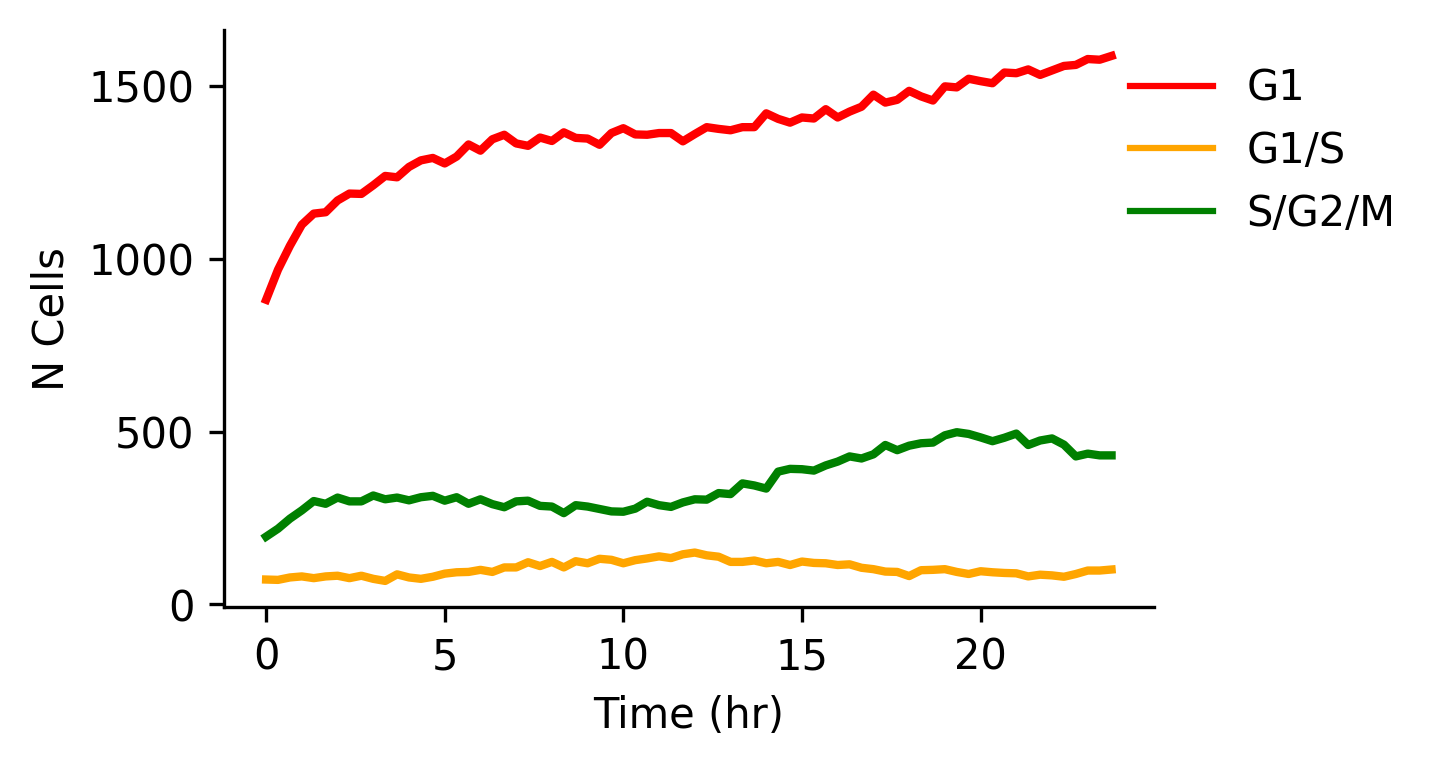

In [4]:
# summarize over time 
minsPerFrame = 20

pdf = df.groupby(['t', 'phase'])['x'].count().reset_index()
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60
pdf = pdf[pdf['phase'] != 'NA']

pm = {
    'G1' : 0,
    'S' : 1,
    'G2' : 2,
}

pdf['pm'] = pdf['phase'].map(pm)
pdf = pdf.sort_values(by='pm')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 2.5

sns.lineplot(data=pdf,
             x='Time',
             y='x',
             hue='phase',
             lw=2,
             palette=['r','orange', 'g'])

plt.xlabel('Time (hr)')
plt.ylabel('N Cells')
sns.despine()
sns.move_legend(plt.gca(), 
                title="",
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
                frameon=False,)

Text(0.5, 1.0, 'Unphased')

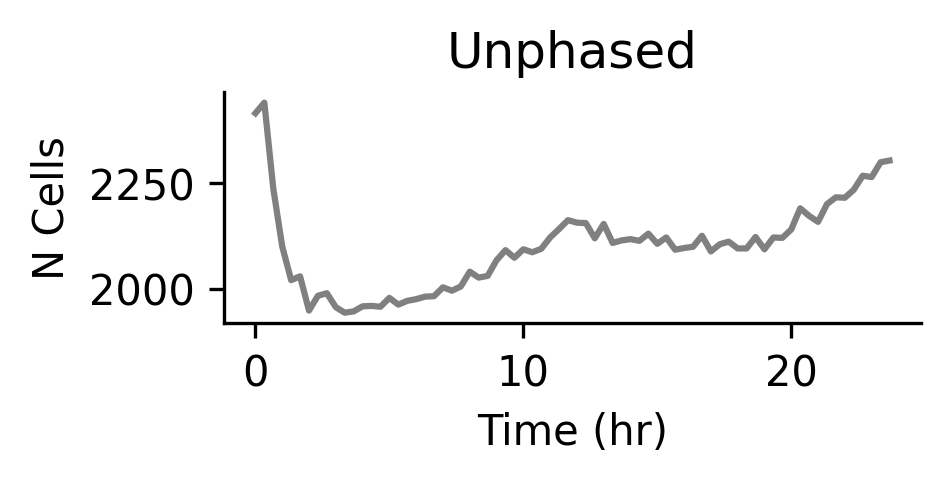

In [5]:
pdf = df.copy()

pdf = df.groupby(['t', 'phase'])['x'].count().reset_index()
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60
pdf = pdf[pdf['phase'] == 'NA']


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 1

sns.lineplot(data=pdf, 
             x='Time',
             y='x', 
             c='grey')

sns.despine()
plt.ylabel('N Cells')
plt.xlabel('Time (hr)')
plt.title('Unphased')

Text(0.5, 0, 'Time (hr)')

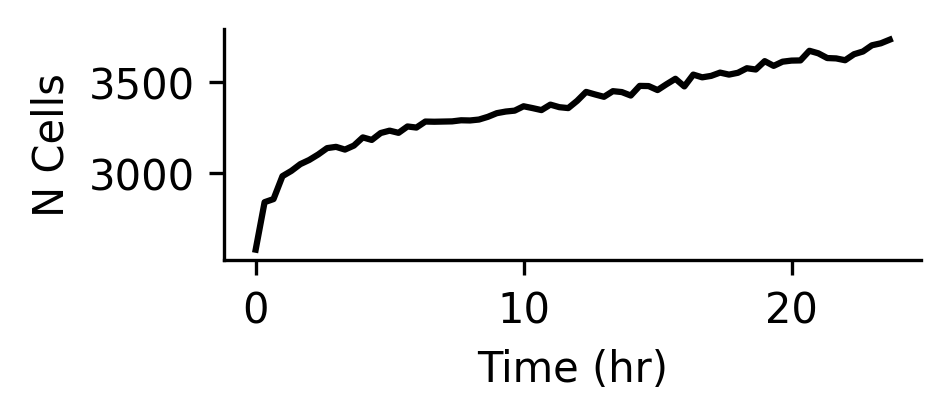

In [6]:
pdf = df.copy()
probTresh = 0.6

pdf = pdf[pdf['prob'] > probTresh]
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60

gx = pdf.groupby('Time')['ID'].nunique().reset_index()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 1

sns.lineplot(data=gx, 
             x='Time',
             y='ID', 
             c='k')

sns.despine()
plt.ylabel('N Cells')
plt.xlabel('Time (hr)')



In [7]:
# pdf = df.copy()
# pdf['Time'] = (pdf['t'] * minsPerFrame) / 60

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 3, 1

# sns.lineplot(data=pdf, 
#              x='Time',
#              y='prob')

# plt.ylabel('Nuclear P(x)')
# plt.xlabel('Time (hr)')
# sns.despine()

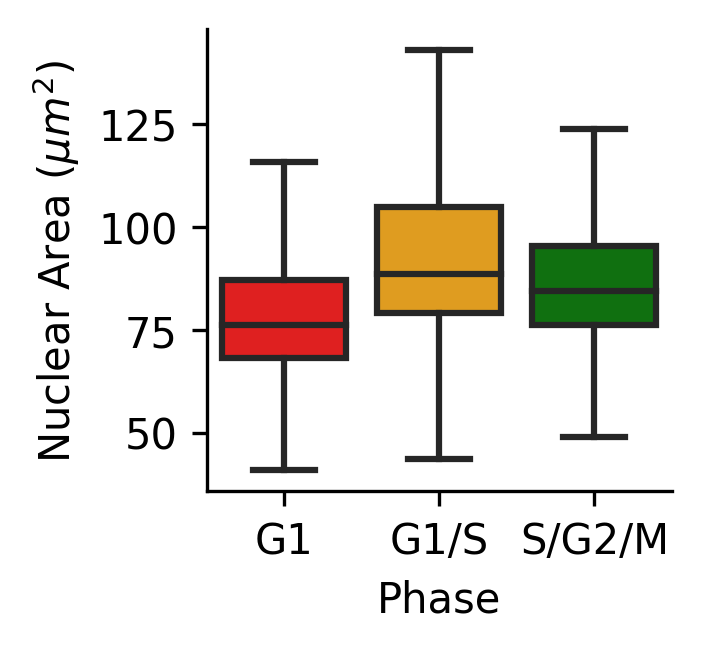

In [8]:
pdf = df.copy()

probTresh = 0.4
pdf = pdf[pdf['phase'] != 'NA']
pdf = pdf[pdf['prob'] > probTresh]


sf = 1.362
pdf['A'] = pdf['area_convex'] * sf

pm = {
    'G1' : 0,
    'S' : 1,
    'G2' : 2,
}

pdf['pm'] = pdf['phase'].map(pm)
pdf = pdf.sort_values(by='pm')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 2
sns.boxplot(data=pdf, 
            y='A',
            x='phase',
            showfliers=False,
            palette=['r','orange', 'g'],
           )


plt.xlabel('Phase')
plt.ylabel(r'Nuclear Area ($\mu m^2$)')
sns.despine()

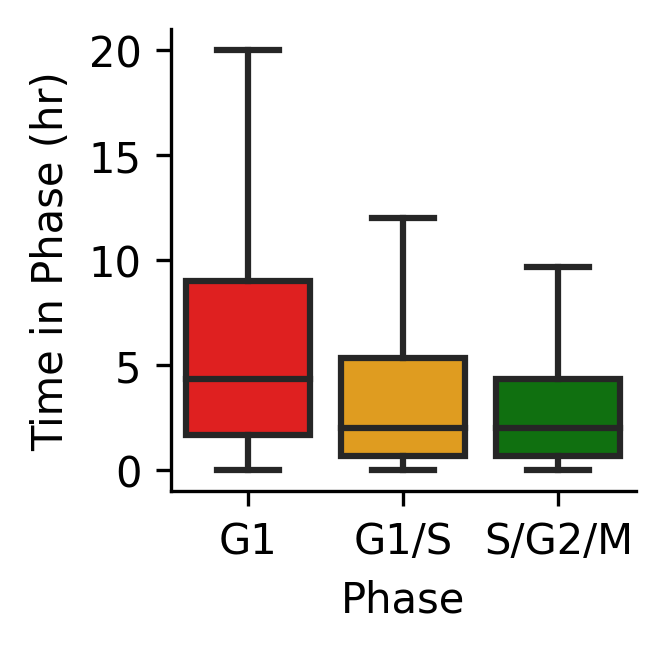

In [9]:
pdf = df.copy()
pdf = pdf[pdf['phase'] != 'NA']
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60
pdf['time_in_phase'] = pdf.groupby(['ID', 'phase']).cumcount()
pdf['PhaseTime'] = (pdf['time_in_phase'] * minsPerFrame) / 60

pm = {
    'G1' : 0,
    'S' : 1,
    'G2' : 2,
}

pdf['pm'] = pdf['phase'].map(pm)
pdf = pdf.sort_values(by='pm')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 2

sns.boxplot(data=pdf, 
            y='PhaseTime',
            x='phase',
            showfliers=False,
            palette=['r','orange', 'g'],
           )

plt.xlabel('Phase')
plt.ylabel(r'Time in Phase (hr)')
sns.despine()

In [29]:
def getTransitions(df, window=3):
    """A function to identify when transitions happen 
    in the phase
    """

    # sort the dataframe
    df = df.sort_values(by=['ID', 't'])

    

    # one_hot = pd.get_mmies(df['phase']).astype(int)
    # df = df.join(one_hot)

    # print(one_hot.head())

    

def simpleSmooth(df, window=3):
    """A function to smooth the dataframe phases """
    df = df.sort_values(by=['ID', 't'])

    df['phaseCat'] = df['phase'].astype('category')

    df['code'] = df['phaseCat'].cat.codes
    df['code'] = df['code'].fillna(-1)
    codeMap = dict( enumerate(df['phaseCat'].cat.categories ) )

    print(codeMap)

    res = []
    
    for ID in df['ID'].unique():
        tdf = df[df['ID'] == ID]
        t = pd.DataFrame(tdf['code'].rolling(window=window).apply(lambda x: mode(x)[0])
        t.columns = ['pred']
        t['ID'] = [ID] * len(tdf)
        t['t'] = tdf['t']

        print(t)

        break
    #     res.append(t)

    # res = pd.concat(res)

    # # merge the smoothed data with the original
    # df = pd.merge(df, t, 
    #               how='left',
    #               left_on=['ID', 't'],
    #               right_on=['ID', 't'])
        
    # # remap numeric
    # df['sm_phase'] = df['pred'].map(codeMap)
    
    # print(df.head())

    #     break

    # print(df.rolling(window=2))
    # print(df.head())
    
    

pdf = df.copy()

simpleSmooth(pdf)

SyntaxError: invalid syntax (3974147699.py, line 35)

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
pdf = df.copy()

probTresh = 0.4
timeThresh = 20 # in hours
nanFlagTresh = 0.05 # percentage of track length

pdf['Time'] = (pdf['t'] * minsPerFrame) / 60
pdf = pdf[pdf['prob'] > probTresh]
pdf['trackLen'] = pdf.groupby('ID')['Time'].transform('max')

pdf = pdf[pdf['trackLen'] > timeThresh]

# flag unphased track flags
pdf['nan_flag'] = np.where(pdf['phase'] == 'NA', 1, 0)
pdf['track_flag'] = pdf.groupby('ID')['nan_flag'].transform('sum')
pdf['unphased'] = pdf['track_flag'] / pdf['trackLen']

# remove tracks with too many unphased points
pdf = pdf[pdf['unphased'] < nanFlagTresh]







# pdf.head()

In [ ]:
pdf = df.copy()
pdf = pdf[pdf['phase'] != 'NA']
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60
pdf['time_in_phase'] = pdf.groupby(['ID', 'phase']).cumcount()
pdf['PhaseTime'] = (pdf['time_in_phase'] * minsPerFrame) / 60


pdf.head()

In [ ]:
# pdf = df.copy()

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 2, 2

# sns.histplot(data=pdf, 
#              x='prob',
#              kde=True,
#              hue='phase',
#              bins=100)

# sns.despine()

In [ ]:
df.columns